In [ ]:
!pip install -q --upgrade pgmpy sktime pandas matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.5/145.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings
warnings.filterwarnings("ignore")

# ---------- sktime ----------
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import temporal_train_test_split

# ---------- pgmpy (robust import logic) ----------
try:
    from pgmpy.estimators import HillClimbSearch                    # present everywhere
    from pgmpy.estimators.scores import BicScore                    # new path (v≥1.0)
    ScoreCls, learner_name = BicScore, "HillClimb (BIC)"
except Exception:
    try:
        # older versions (<1.0) expose BicScore at top level
        from pgmpy.estimators import HillClimbSearch, BicScore
        ScoreCls, learner_name = BicScore, "HillClimb (BIC‑legacy)"
    except Exception:
        from pgmpy.estimators import PC
        ScoreCls, learner_name = None, "PC Algorithm (fallback)"

# Model class: DiscreteBayesianNetwork (new) → fallback to BayesianNetwork (old)
try:
    from pgmpy.models import DiscreteBayesianNetwork as DBN
except ImportError:
    from pgmpy.models import BayesianNetwork as DBN          # for pgmpy <1.0

from pgmpy.inference import VariableElimination

print(f"✓  Using learner: {learner_name}")
print(f"✓  Using model class: {DBN.__name__}")

✓  Using learner: PC Algorithm (fallback)
✓  Using model class: DiscreteBayesianNetwork


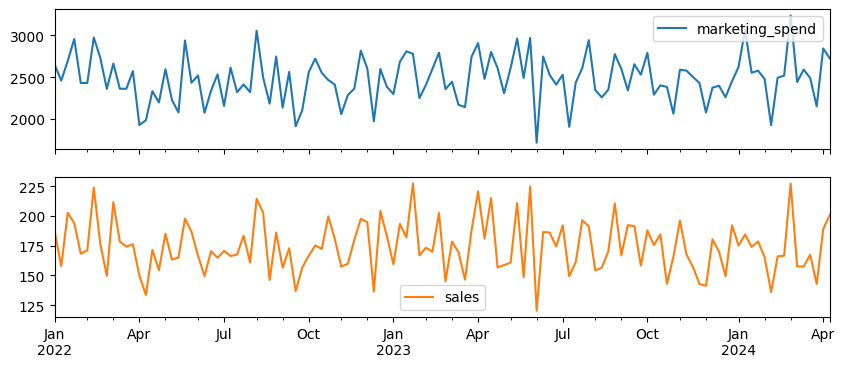

In [ ]:
np.random.seed(42)
weeks = pd.date_range("2022-01-01", periods=120, freq="W")

marketing_spend  = np.random.normal(2500, 300, size=len(weeks))
discount_rate    = np.random.uniform(0.05, 0.4, size=len(weeks))
competitor_price = np.random.normal(50, 5,  size=len(weeks))

sales = (
    120
    + 0.06 * marketing_spend
    - 80  * discount_rate
    - 1.5 * competitor_price
    + np.random.normal(0, 8,  size=len(weeks))
)

df = pd.DataFrame({
    "marketing_spend":  marketing_spend,
    "discount_rate":    discount_rate,
    "competitor_price": competitor_price,
    "sales":            sales
}, index=weeks)

df[["marketing_spend", "sales"]].plot(subplots=True, figsize=(10,4)); plt.show()

In [ ]:
# Discretise for pgmpy
df_disc = df.copy()
for col in df_disc:
    df_disc[col] = pd.qcut(df_disc[col], 4, labels=False)

# 4.a  Score‑based learner (preferred)
if ScoreCls is not None:
    hc   = HillClimbSearch(df_disc, scoring_method=ScoreCls(df_disc))
    dag  = hc.estimate()
    bn   = DBN(dag.edges())

# 4.b  PC fallback (returns PDAG → convert to DAG)
else:
    from pgmpy.estimators import PC
    pc   = PC(data=df_disc)
    pdag = pc.estimate()
    try:
        dag = pdag.to_dag()                 # pgmpy ≥1.0
    except AttributeError:
        dag = pdag                          # older pgmpy already returns DAG
    bn = DBN(dag.edges())

print("Learned edges:", list(bn.edges()))

  0%|          | 0/5 [00:00<?, ?it/s]

Learned edges: [('sales', 'marketing_spend')]


In [ ]:
#Parameter learning & inference (now bullet‑proof)
bn.fit(df_disc)                 # Works for both DBN and old BayesianNetwork
infer = VariableElimination(bn)

print("Baseline P(sales):")
print(infer.query(["sales"]))

Baseline P(sales):
+----------+--------------+
| sales    |   phi(sales) |
+==========+==============+
| sales(0) |       0.2500 |
+----------+--------------+
| sales(1) |       0.2500 |
+----------+--------------+
| sales(2) |       0.2500 |
+----------+--------------+
| sales(3) |       0.2500 |
+----------+--------------+


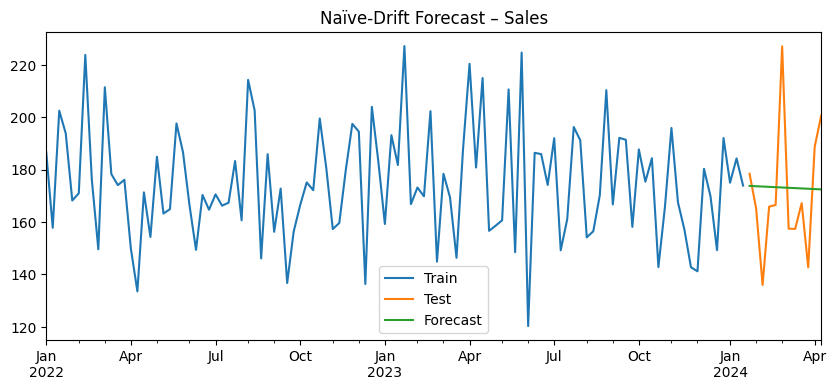

In [ ]:
# Baseline time‑series forecast with sktime
y_tr, y_te = temporal_train_test_split(df["sales"], test_size=12)
forecaster = NaiveForecaster(strategy="drift").fit(y_tr)
fh = list(range(1, len(y_te)+1))
y_pred = forecaster.predict(fh)

ax = y_tr.plot(label="Train", figsize=(10,4))
y_te.plot(label="Test", ax=ax)
y_pred.plot(label="Forecast", ax=ax)
plt.title("Naïve‑Drift Forecast – Sales"); plt.legend(); plt.show()

P(sales | do(marketing_spend=high, discount_rate=high))
+----------+--------------+
| sales    |   phi(sales) |
+==========+==============+
| sales(0) |       0.2500 |
+----------+--------------+
| sales(1) |       0.2500 |
+----------+--------------+
| sales(2) |       0.2500 |
+----------+--------------+
| sales(3) |       0.2500 |
+----------+--------------+


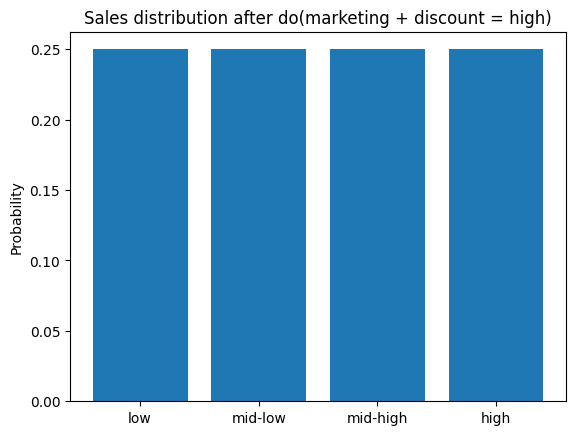

In [ ]:
#Causal intervention (high marketing + high discount)
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

# 1. Clone the original network
intervened_bn = DBN(bn.edges())
intervened_bn.add_nodes_from(bn.nodes())

# 2. Remove parents of intervention nodes (do-operation)
for node in ["marketing_spend", "discount_rate"]:
    parents = intervened_bn.get_parents(node)
    for p in parents:
        intervened_bn.remove_edge(p, node)

# 3. Copy CPDs, replacing intervention nodes with forced CPDs (P=1 at high=3)
original_cpds = {cpd.variable: cpd for cpd in bn.get_cpds()}
forced_cpds = []

for node in intervened_bn.nodes():
    if node == "marketing_spend":
        # Force to label 3 (high)
        forced_cpds.append(TabularCPD(variable="marketing_spend", variable_card=4,
                                      values=[[0], [0], [0], [1]]))
    elif node == "discount_rate":
        forced_cpds.append(TabularCPD(variable="discount_rate", variable_card=4,
                                      values=[[0], [0], [0], [1]]))
    else:
        forced_cpds.append(original_cpds[node])

intervened_bn.add_cpds(*forced_cpds)

# 4. Validate and infer
intervened_bn.check_model()
intervened_infer = VariableElimination(intervened_bn)

posterior = intervened_infer.query(variables=["sales"])

# 5. Show result
print("P(sales | do(marketing_spend=high, discount_rate=high))")
print(posterior)

plt.bar(["low", "mid-low", "mid-high", "high"], posterior.values)
plt.title("Sales distribution after do(marketing + discount = high)")
plt.ylabel("Probability")
plt.show()